In [1]:
import numpy as np
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
# torch.cuda.get_device_name(0)

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [5]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [6]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """
        # for i in range():
        #     f'y_{i}' = self.modules[i].forward(f'y_{i-1}')
        # Your code goes here. ################################################
        self.output = input
        for module in self.modules:
            self.output = module.updateOutput(self.output)
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # Your code goes here. ################################################
        outputs = [input]
        for module in self.modules:
            outputs.append(module.updateOutput(outputs[-1]))
        current_grad = gradOutput
        for i in range(len(self.modules)-1, -1, -1):
            current_grad = self.modules[i].backward(outputs[i], current_grad)
    
        self.gradInput = current_grad
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [7]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        self.input = input
        self.output = np.dot(input, self.W.T) + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.dot(gradOutput, self.W)
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradW += np.dot(gradOutput.T, input)
        self.gradb += np.sum(gradOutput, axis=0)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [8]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        e = np.exp(self.output)
        # Your code goes here. ################################################
        self.output = e/np.sum(e, axis=1, keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        dot_product = np.sum(self.output * gradOutput, axis=1, keepdims=True)
        self.gradInput = self.output * (gradOutput - dot_product)
        return self.gradInput
    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [9]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        # Your code goes here. ################################################
        self.output = self.output - np.log(np.sum(np.exp(self.output), axis=1, keepdims=True))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        softmax = np.exp(self.output)
        
        # Compute sum over gradients (batch-wise)
        sum_grad = np.sum(gradOutput, axis=1, keepdims=True)
        
        # Compute gradient
        self.gradInput = gradOutput - softmax * sum_grad
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [10]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None
        self.cache = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.training:
            batch_mean = np.mean(input, axis=0, keepdims=True)
            batch_variance = np.var(input, axis=0, keepdims=True)
            self.moving_mean = self.moving_mean*self.alpha + batch_mean*(1 - self.alpha) if self.moving_mean is not None else batch_mean
            self.moving_variance = self.moving_variance*self.alpha + batch_variance*(1 - self.alpha) if self.moving_variance is not None else batch_variance
            self.output = (input - batch_mean) / np.sqrt(batch_variance+ self.EPS)
            self.cache = (batch_mean, batch_variance)
        else:
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS) 
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            batch_mean, batch_variance = self.cache
            m = input.shape[0]
            d_var = np.sum(gradOutput * (input - batch_mean) * -0.5 * (batch_variance + self.EPS)**(-1.5), axis=0, keepdims=True)
            d_mean = np.sum(gradOutput * -1 / np.sqrt(batch_variance + self.EPS), axis=0, keepdims=True) + \
                   d_var * np.sum(-2 * (input - batch_mean), axis=0, keepdims=True) / m
            # d_mean = np.sum(gradOutput * (-1) / np.sqrt(batch_variance + self.EPS), axis=0) + \
            #        d_var * (-2) * np.mean(input - batch_mean, axis=0)
            self.gradInput = gradOutput / np.sqrt(batch_variance + self.EPS) + \
                            d_var * 2 * (input - batch_mean) / m + \
                            d_mean / m
        else:
            self.gradInput = gradOutput / np.sqrt(self.moving_variance + self.EPS)
        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"

In [11]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = gamma * x + beta
       where gamma, beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [12]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.training:
            self.mask = np.random.binomial(size=input.shape, n=1, p=(1 - self.p)).astype('float') / (1 - self.p)
            self.output = input * self.mask
        else:
            self.output = input
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            self.gradInput = gradOutput * self.mask
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return "Dropout"

## 6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [13]:
# class Conv2d(Module):
#     def __init__(self, in_channels, out_channels, kernel_size,
#                  stride=1, padding=0, bias=True, padding_mode='zeros'):
#         super(Conv2d, self).__init__()

#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.padding = padding
#         self.bias = bias
#         self.padding_mode = padding_mode

#     def updateOutput(self, input):
#         # Your code goes here. ################################################
        
#         return  self.output

#     def updateGradInput(self, input, gradOutput):
#         # Your code goes here. ################################################
        
#         return self.gradInput

#     def __repr__(self):
#         return "Conv2d"

In [14]:
# import numpy as np

class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='valid', bias=True, padding_mode='zeros'):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding
        self.padding_mode = padding_mode
        self.bias = bias

        # Инициализация параметров
        self.weight = np.random.randn(out_channels, in_channels, *self.kernel_size) * 0.1
        if self.bias:
            self.bias_params = np.zeros(out_channels)
        
        # Градиенты
        self.gradWeight = np.zeros_like(self.weight)
        if self.bias:
            self.gradBias = np.zeros_like(self.bias_params)
        
        self.last_input = None
        self.last_padding = ((0, 0), (0, 0))

    def _calculate_same_padding(self, in_height, in_width):
        out_height = np.ceil(in_height / self.stride[0]).astype(int)
        out_width = np.ceil(in_width / self.stride[1]).astype(int)
        pad_h = max(0, (out_height - 1) * self.stride[0] + self.kernel_size[0] - in_height)
        pad_w = max(0, (out_width - 1) * self.stride[1] + self.kernel_size[1] - in_width)
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        return ((pad_top, pad_bottom), (pad_left, pad_right))

    def _apply_padding(self, input, padding):
        if padding == ((0, 0), (0, 0)):
            return input
        
        pad_top, pad_bottom = padding[0]
        pad_left, pad_right = padding[1]
        
        pad_width = (
            (0, 0), 
            (0, 0),
            (pad_top, pad_bottom),
            (pad_left, pad_right)
        )
        
        if self.padding_mode == 'zeros':
            return np.pad(input, pad_width, mode='constant', constant_values=0)
        elif self.padding_mode == 'replicate':
            return np.pad(input, pad_width, mode='edge')
        elif self.padding_mode == 'reflect':
            return np.pad(input, pad_width, mode='symmetric')
        else:
            raise ValueError(f"Unsupported padding mode: {self.padding_mode}")

    def updateOutput(self, input):
        batch_size, in_channels, in_height, in_width = input.shape
        
        if self.padding == 'same':
            current_padding = self._calculate_same_padding(in_height, in_width)
        elif isinstance(self.padding, int):
            current_padding = ((self.padding, self.padding), (self.padding, self.padding))
        elif isinstance(self.padding, tuple) and len(self.padding) == 2:
            if isinstance(self.padding[0], int):
                current_padding = ((self.padding[0], self.padding[0]), (self.padding[1], self.padding[1]))
            else:
                current_padding = self.padding
        else:
            current_padding = ((0, 0), (0, 0))
        
        input_padded = self._apply_padding(input, current_padding)
        self.last_input = input_padded
        self.last_padding = current_padding
        out_height = (input_padded.shape[2] - self.kernel_size[0]) // self.stride[0] + 1
        out_width = (input_padded.shape[3] - self.kernel_size[1]) // self.stride[1] + 1
        self.output = np.zeros((batch_size, self.out_channels, out_height, out_width))
        
        for b in range(batch_size):
            for oc in range(self.out_channels):
                for oh in range(out_height):
                    for ow in range(out_width):
                        h_start = oh * self.stride[0]
                        w_start = ow * self.stride[1]
                        h_end = h_start + self.kernel_size[0]
                        w_end = w_start + self.kernel_size[1]
                        
                        window = input_padded[b, :, h_start:h_end, w_start:w_end]
                        self.output[b, oc, oh, ow] = np.sum(window * self.weight[oc])
                        
                        if self.bias:
                            self.output[b, oc, oh, ow] += self.bias_params[oc]
        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size, _, out_h, out_w = gradOutput.shape
        input_padded = self.last_input
        grad_input_padded = np.zeros_like(input_padded)
        
        for b in range(batch_size):
            for oc in range(self.out_channels):
                for oh in range(out_h):
                    for ow in range(out_w):
                        h_start = oh * self.stride[0]
                        w_start = ow * self.stride[1]
                        h_end = h_start + self.kernel_size[0]
                        w_end = w_start + self.kernel_size[1]
                        
                        window = input_padded[b, :, h_start:h_end, w_start:w_end]
                        self.gradWeight[oc] += window * gradOutput[b, oc, oh, ow]
                        grad_input_padded[b, :, h_start:h_end, w_start:w_end] += self.weight[oc] * gradOutput[b, oc, oh, ow]
                
                if self.bias:
                    self.gradBias[oc] += np.sum(gradOutput[b, oc])
        
        pad_top, pad_bottom = self.last_padding[0]
        pad_left, pad_right = self.last_padding[1]
        self.gradInput = grad_input_padded[:, :, pad_top:-pad_bottom if pad_bottom !=0 else None, pad_left:-pad_right if pad_right !=0 else None]
        
        return self.gradInput

    def __repr__(self):
        return 'Conv2d'

In [15]:
# hyperparams = [
#             {'batch_size': 8, 'in_channels': 3, 'out_channels': 6, 'height': 32, 'width': 32,
#              'kernel_size': 3, 'stride': 1, 'padding': 1, 'bias': True, 'padding_mode': 'zeros'}
#         ]
# np.random.seed(42)
# torch.manual_seed(42)

# for _ in range(100):
#     for params in hyperparams:
#         batch_size = params['batch_size']
#         in_channels = params['in_channels']
#         out_channels = params['out_channels']
#         height = params['height']
#         width = params['width']
#         kernel_size = params['kernel_size']
#         stride = params['stride']
#         padding = params['padding']
#         bias = params['bias']
#         padding_mode = params['padding_mode']

#         custom_layer = Conv2d(in_channels, out_channels, kernel_size,
#                             stride=stride, padding=padding, bias=bias,
#                             padding_mode=padding_mode)
#         custom_layer.train()

#         torch_layer = torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                                     stride=stride, padding=padding, bias=bias,
#                                     padding_mode=padding_mode)

#         custom_layer.weight = torch_layer.weight.detach().numpy().copy()
# #         if bias:
# #             custom_layer.bias = torch_layer.bias.detach().numpy().copy()

#         layer_input = np.random.randn(batch_size, in_channels, height, width).astype(np.float32)
#         input_var = torch.tensor(layer_input, requires_grad=True)

#         custom_output = custom_layer.updateOutput(layer_input)
#         torch_output = torch_layer(input_var)
#         self.assertTrue(
#             np.allclose(torch_output.detach().numpy(), custom_output, atol=1e-6))

#         next_layer_grad = np.random.randn(*torch_output.shape).astype(np.float32)
#         custom_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
#         torch_output.backward(torch.tensor(next_layer_grad))
#         torch_grad = input_var.grad.detach().numpy()
#         self.assertTrue(
#         np.allclose(torch_grad, custom_grad, atol=1e-5))

In [16]:
# torch_layer.bias.detach().numpy().copy()

## 7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [17]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride
        self.padding = (padding, padding) if isinstance(padding, int) else padding
        self.cache = None
        
    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch, num_channels, H_in, W_in = input.shape
        H_out = ((H_in + 2*self.padding[0] - self.kernel_size[0])//self.stride[0] + 1)
        W_out = ((W_in + 2*self.padding[1] - self.kernel_size[1])//self.stride[1] + 1)
        
        self.output = np.zeros((batch, num_channels, H_out, W_out))
        self.indices = np.zeros((batch, num_channels, H_out, W_out, 2), dtype=int)
        padding = np.pad(input, 
                            ((0,0), (0,0), (self.padding[0],self.padding[0]), (self.padding[1], self.padding[1])), 
                            mode='constant')
        for b in range(batch):
            for c in range(num_channels):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * self.stride[0]
                        h_end = h_start + self.kernel_size[0]
                        w_start = j * self.stride[1]
                        w_end = w_start + self.kernel_size[1]

                        window = padding[b, c, h_start:h_end, w_start:w_end]
                        self.output[b, c, i, j] = np.max(window)
                        max_idx = np.unravel_index(np.argmax(window), window.shape)
                        self.indices[b, c, i, j] = [h_start + max_idx[0], w_start + max_idx[1]]
        self.cache = (batch, num_channels, H_in, W_in)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch, num_channels, H_in, W_in = self.cache
        out_shape = (batch, num_channels, 
                       H_in + 2*self.padding[0], W_in + 2*self.padding[1])
        self.gradInput = np.zeros(out_shape)
        for b in range(batch):
            for c in range(num_channels):
                for i in range(gradOutput.shape[2]):
                    for j in range(gradOutput.shape[3]):
                        h, w = self.indices[b, c, i, j]
                        self.gradInput[b, c, h, w] += gradOutput[b, c, i, j]
        if self.padding[0] > 0 or self.padding[1] > 0:
            self.gradInput = self.gradInput[:, :, self.padding[0]:-self.padding[0], self.padding[1]:-self.padding[1]] if self.padding[0] > 0 and self.padding[1] > 0 else \
                           self.gradInput[:, :, self.padding[0]:-self.padding[0], :] if self.padding[0] > 0 else \
                           self.gradInput[:, :, :, self.padding[1]:-self.padding[1]]
        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"

class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride
        self.padding = (padding, padding) if isinstance(padding, int) else padding
        self.cache = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        batch, num_channels, H_in, W_in = input.shape
        H_out = ((H_in + 2*self.padding[0] - self.kernel_size[0])//self.stride[0] + 1)
        W_out = ((W_in + 2*self.padding[1] - self.kernel_size[1])//self.stride[1] + 1)
        
        self.output = np.zeros((batch, num_channels, H_out, W_out))
        self.indices = np.zeros((batch, num_channels, H_out, W_out, 2), dtype=int)
        padding = np.pad(input, 
                            ((0,0), (0,0), (self.padding[0],self.padding[0]), (self.padding[1], self.padding[1])), 
                            mode='constant')
        for b in range(batch):
            for c in range(num_channels):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * self.stride[0]
                        h_end = h_start + self.kernel_size[0]
                        w_start = j * self.stride[1]
                        w_end = w_start + self.kernel_size[1]

                        window = padding[b, c, h_start:h_end, w_start:w_end]
                        self.output[b, c, i, j] = np.mean(window)
        self.cache = (batch, num_channels, H_in, W_in)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        batch, num_channels, H_in, W_in = self.cache
        out_shape = (batch, num_channels, 
                       H_in + 2*self.padding[0], W_in + 2*self.padding[1])
        self.gradInput = np.zeros(out_shape)
        norm_win = 1 / (self.kernel_size[0] * self.kernel_size[1])
        for b in range(batch):
            for c in range(num_channels):
                for i in range(gradOutput.shape[2]):
                    for j in range(gradOutput.shape[3]):
                        h_start = i * self.stride[0]
                        h_end = h_start + self.kernel_size[0]
                        w_start = j * self.stride[1]
                        w_end = w_start + self.kernel_size[1]
                        self.gradInput[b, c, h_start:h_end, w_start:w_end] += gradOutput[b, c, i, j] * norm_win
                        
        if self.padding[0] > 0 or self.padding[1] > 0:
            self.gradInput = self.gradInput[:, :, self.padding[0]:-self.padding[0], self.padding[1]:-self.padding[1]] if self.padding[0] > 0 and self.padding[1] > 0 else \
                           self.gradInput[:, :, self.padding[0]:-self.padding[0], :] if self.padding[0] > 0 else \
                           self.gradInput[:, :, :, self.padding[1]:-self.padding[1]]
        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

## 8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

## 9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [18]:
class Flatten(Module):
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()

        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.start_dim = self.start_dim if self.start_dim >= 0 else len(input.shape) + self.start_dim
        self.end_dim = self.end_dim if self.end_dim >= 0 else len(input.shape) + self.end_dim
        to_shape = list(input.shape[:self.start_dim])
        flattened_size = 1
        for _ in input.shape[self.start_dim:self.end_dim+1]:
            flattened_size *= _
        to_shape.append(flattened_size)
        to_shape.extend(input.shape[self.end_dim+1:])
        self.output = input.reshape(to_shape)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput.reshape(input.shape)
        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [19]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [20]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, input * self.slope)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, gradOutput * self.slope)
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [21]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.alpha*(np.exp(input) - 1))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, self.alpha*(np.exp(input))*gradOutput)
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [22]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.log(1 + np.exp(input))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput/(1 + np.exp(-input))
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

## 13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [23]:
class Gelu(Module):
    def __init__(self):
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # self.output = 0.5*input*(1 + np.tanh(np.sqrt(2/np.pi) * (input + 0.044715*input**3))) #НЕ РАБОТАЕТ, ПОСКОЛЬКУ В pytorch ИСПОЛЬЗУЕТСЯ ДРУГАЯ АППРОКСИМАЦИЯ -> на тесте не сходится
        self.output = 0.5 * input * (1 + torch.erf(torch.from_numpy(input / np.sqrt(2))).numpy())
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput * (0.5*(1 + torch.erf(torch.from_numpy(input/np.sqrt(2))).numpy()) + (input * np.exp(-0.5*input**2))/np.sqrt(2*np.pi))
        return self.gradInput

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [24]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [25]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [26]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):
        # return loss of loss function

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        self.output = -np.sum(target * np.log(input_clamp)) / target.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        # return gradient of loss function

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        self.gradInput = -target / (input_clamp * target.shape[0])
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [27]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        self.output = -np.sum(target * input) / target.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        self.gradInput = -target / target.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

# 2

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.✅
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.✅
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.✅
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.✅
3. Наличие шедулера для lr.✅
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.✅
6. Свитч лося (метрики) и оптимайзера.

In [28]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

In [29]:
class AdamOptimizer:
    def __init__(self, model, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):

        self.model = model
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0
        self.m = []
        self.v = []
        self.params = self._get_all_parameters()
        for param in self.params:
            self.m.append(np.zeros_like(param))
            self.v.append(np.zeros_like(param))
    
    def _get_all_parameters(self):
        params = []
        modules = self.model.modules if hasattr(self.model, 'modules') else [self.model]
        
        for module in modules:
            if hasattr(module, 'getParameters'):
                module_params = module.getParameters()
                if module_params:  # Skip empty lists
                    if isinstance(module_params[0], (list, tuple, np.ndarray)):
                        params.extend(module_params)
                    else:
                        params.append(module_params)
        return params
    
    def _get_all_gradients(self):
        grads = []
        modules = self.model.modules if hasattr(self.model, 'modules') else [self.model]
        
        for module in modules:
            if hasattr(module, 'getGradParameters'):
                module_grads = module.getGradParameters()
                if module_grads:  # Skip empty lists
                    if isinstance(module_grads[0], (list, tuple, np.ndarray)):
                        grads.extend(module_grads)
                    else:
                        grads.append(module_grads)
        return grads
    
    def step(self):
        self.t += 1
        grads = self._get_all_gradients()
        
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            param -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
    
    def zero_grad(self):
        modules = self.model.modules if hasattr(self.model, 'modules') else [self.model]
        for module in modules:
            if hasattr(module, 'zeroGradParameters'):
                module.zeroGradParameters()

In [30]:
class LRScheduler:
    def __init__(self, optimizer, initial_lr):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.current_lr = initial_lr
    
    def step(self, epoch=None, metrics=None):
        self.update_lr(epoch, metrics)
        self.apply_lr()
    
    def update_lr(self, epoch, metrics):
        pass
    
    def apply_lr(self):
        self.optimizer.lr = self.current_lr
    
    def get_lr(self):
        return self.current_lr


class StepLR(LRScheduler):
    def __init__(self, optimizer, initial_lr, step_size, gamma=0.1):
        super().__init__(optimizer, initial_lr)
        self.step_size = step_size
        self.gamma = gamma
    
    def update_lr(self, epoch, metrics=None):
        if epoch > 0 and epoch % self.step_size == 0:
            self.current_lr = self.initial_lr * (self.gamma ** (epoch // self.step_size))


class ReduceLROnPlateau(LRScheduler):
    def __init__(self, optimizer, initial_lr, factor=0.1, patience=10, min_lr=1e-6):
        super().__init__(optimizer, initial_lr)
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.best_metric = None
        self.wait = 0
    
    def update_lr(self, epoch, metrics):
        if metrics is None:
            return
            
        if self.best_metric is None:
            self.best_metric = metrics
        elif metrics > self.best_metric:
            self.best_metric = metrics
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(self.current_lr * self.factor, self.min_lr)
                if new_lr < self.current_lr:
                    self.current_lr = new_lr
                    self.wait = 0

In [44]:
class MSERegressionTrainer:
    def __init__(self, model, criterion, optimizer, scheduler=None, patience=5):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.patience = patience
        self.train_history = {'loss': [], 'mse': []}
        self.val_history = {'loss': [], 'mse': []}
        self.best_loss = np.inf
        self.best_epoch = 0
        self.best_params = None

    def _save_best_params(self):
        self.best_params = []
        modules = self.model.modules if hasattr(self.model, 'modules') else [self.model]
        
        for module in modules:
            if hasattr(module, 'getParameters'):
                params = module.getParameters()
                if params:
                    self.best_params.append([p.copy() for p in params])

    def _load_best_params(self):
        if self.best_params is None:
            return
            
        idx = 0
        modules = self.model.modules if hasattr(self.model, 'modules') else [self.model]
        
        for module in modules:
            if hasattr(module, 'getParameters'):
                params = module.getParameters()
                if params:
                    for i in range(len(params)):
                        params[i][...] = self.best_params[idx][i]
                    idx += 1
    
    def compute_metrics(self, y_pred, y_true):
        mse = np.mean((y_pred - y_true)**2)
        return {'mse': mse}
    
    def train_epoch(self, X, y, batch_size=32, training=True):
        epoch_loss = 0
        epoch_metrics = {'mse': 0}
        num_batches = int(np.ceil(len(X) / batch_size))
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X[start:end]
            y_batch = y[start:end]
            output = self.model.forward(X_batch)
            loss = self.criterion.updateOutput(output, y_batch)
            metrics = self.compute_metrics(output, y_batch)
            epoch_loss += loss * len(X_batch)
            for k in epoch_metrics:
                epoch_metrics[k] += metrics[k] * len(X_batch)
            if training:
                grad_output = self.criterion.updateGradInput(output, y_batch)
                self.model.backward(X_batch, grad_output)
                self.optimizer.step()
                self.optimizer.zero_grad()
        
        return epoch_loss, epoch_metrics
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        patience_counter = 0
        
        for epoch in range(epochs):
            train_loss, train_metrics = self.train_epoch(X_train, y_train, batch_size, training=True)
            self.train_history['loss'].append(train_loss)
            self.train_history['mse'].append(train_metrics['mse'])
            
            val_loss, val_metrics = self.train_epoch(X_val, y_val, batch_size, training=False)
            self.val_history['loss'].append(val_loss)
            self.val_history['mse'].append(val_metrics['mse'])
            
            if self.scheduler is not None:
                self.scheduler.step(epoch, -val_loss)
            
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_epoch = epoch
                patience_counter = 0
                self._save_best_params()
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
            
            print(f"Epoch {epoch + 1}/{epochs}: "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"LR: {self.optimizer.lr if hasattr(self.optimizer, 'lr') else 'N/A':.6f}")
        
        self._load_best_params()
        print(f"Best model restored from epoch {self.best_epoch + 1}")
        
        self.plot_history()
        return self.train_history, self.val_history
    
    def plot_history(self):
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(np.log(self.train_history['loss']), label='Train Loss')
        plt.plot(np.log(self.val_history['loss']), label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss (logarithmized)')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(np.log(self.train_history['mse']), label='Train MSE')
        plt.plot(np.log(self.val_history['mse']), label='Validation MSE')
        plt.title('Training and Validation MSE')
        plt.xlabel('Epoch')
        plt.ylabel('MSE (logarithmized)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

Epoch 1/200: Train Loss: 197291572.5354 | Val Loss: 861142.1633 | LR: 0.010000
Epoch 2/200: Train Loss: 1523223.0619 | Val Loss: 239911.8809 | LR: 0.010000
Epoch 3/200: Train Loss: 456644.2299 | Val Loss: 78521.4273 | LR: 0.010000
Epoch 4/200: Train Loss: 169907.2232 | Val Loss: 36765.4294 | LR: 0.010000
Epoch 5/200: Train Loss: 142787.0983 | Val Loss: 13345.8306 | LR: 0.010000
Epoch 6/200: Train Loss: 250563.7334 | Val Loss: 9280.4851 | LR: 0.010000
Epoch 7/200: Train Loss: 225912.1296 | Val Loss: 15897.6263 | LR: 0.010000
Epoch 8/200: Train Loss: 415258.4840 | Val Loss: 12381.1499 | LR: 0.010000
Epoch 9/200: Train Loss: 55184.0734 | Val Loss: 51351.6592 | LR: 0.010000
Epoch 10/200: Train Loss: 267509.7382 | Val Loss: 66009.6970 | LR: 0.010000
Epoch 11/200: Train Loss: 433837.3771 | Val Loss: 29215.4031 | LR: 0.005000
Epoch 12/200: Train Loss: 9048.5597 | Val Loss: 1631.7873 | LR: 0.005000
Epoch 13/200: Train Loss: 6160.6736 | Val Loss: 2299.2984 | LR: 0.005000
Epoch 14/200: Train Los

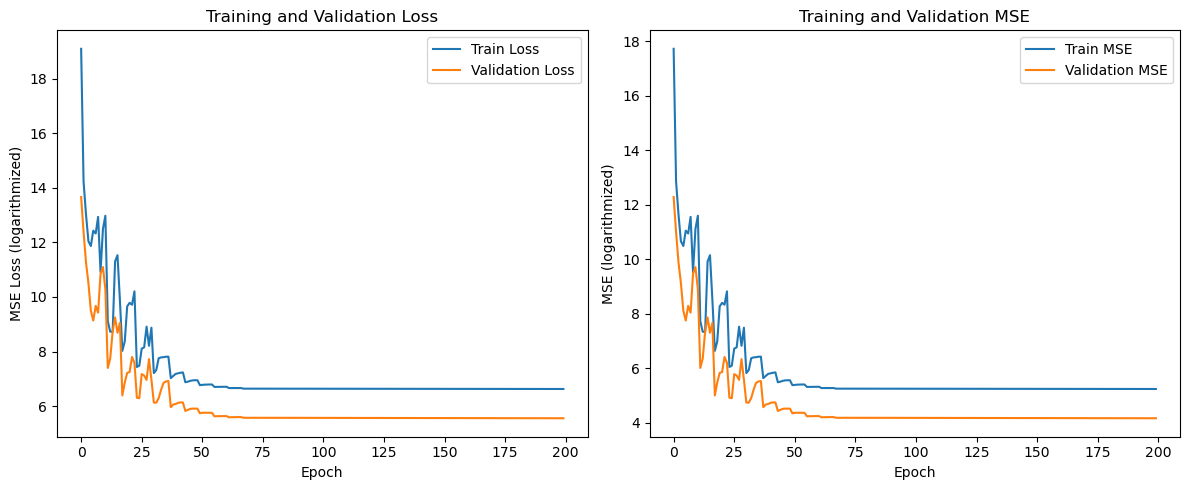

In [45]:
n = 10 #число фичей
m = 4 #число таргетов

X, y = make_regression(n_samples=30000, n_features=n, n_targets=m, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
# scaler_X = StandardScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_val = scaler_X.transform(X_val)
# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(y_train)
# y_val = scaler_y.transform(y_val)

model_small = Sequential()
model_small.add(Linear(n, 64))
model_small.add(ReLU())
model_small.add(Linear(64, 32))
model_small.add(ELU())
model_small.add(Linear(32, m))

model_med = Sequential()
model_med.add(Linear(n, 64))
model_med.add(BatchNormalization())
model_med.add(ReLU())
model_med.add(Dropout(0.5))
model_med.add(Linear(64, 32))
model_med.add(BatchNormalization())
model_med.add(ELU())
model_med.add(Linear(32, m))

model_large = Sequential()
model_large.add(Linear(n, 64))
model_large.add(BatchNormalization())
model_large.add(ReLU())
model_large.add(Dropout(0.5))
model_large.add(Linear(64, 64))
model_large.add(BatchNormalization())
model_large.add(ELU())
model_large.add(Dropout(0.5))
model_large.add(Linear(64, 32))
model_large.add(BatchNormalization())
model_large.add(Gelu())
model_large.add(Dropout(0.5))
model_large.add(Linear(32, m))

model = model_small
optimizer = AdamOptimizer(model, lr=0.01)
criterion = MSECriterion()
scheduler = ReduceLROnPlateau(optimizer, initial_lr=0.01, factor=0.5, patience=5, min_lr=1e-5)

trainer = MSERegressionTrainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    patience=10
)
train_history, val_history = trainer.train(
    X_train, y_train,
    X_val, y_val,
    epochs=200,
    batch_size=32
)

# def evaluate_model(X, y, model):
#     model.evaluate()
#     predictions = model.forward(X)
#     mse = np.mean((predictions - y)**2)
#     print(f"Test MSE: {mse:.4f}")
#     return predictions
# test_predictions = evaluate_model(X_test, y_test, model)